In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [2]:

# Optional imports - handle missing packages gracefully
try:
    import nltk
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer
    NLTK_AVAILABLE = True
    
    # Download required NLTK data
    try:
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)
        nltk.download('wordnet', quiet=True)
        nltk.download('vader_lexicon', quiet=True)
    except:
        pass
except ImportError:
    NLTK_AVAILABLE = False
    print("NLTK not available. Using basic text preprocessing.")

try:
    from textblob import TextBlob
    TEXTBLOB_AVAILABLE = True
except ImportError:
    TEXTBLOB_AVAILABLE = False
    print("TextBlob not available. Skipping rule-based sentiment analysis.")

try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    PLOTTING_AVAILABLE = True
except ImportError:
    PLOTTING_AVAILABLE = False
    print("Matplotlib/Seaborn not available. Skipping visualizations.")

try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    WORDCLOUD_AVAILABLE = False
    print("WordCloud not available. Skipping word cloud generation.")

class SentimentAnalyzer:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        self.models = {
            'logistic': LogisticRegression(random_state=42),
            'naive_bayes': MultinomialNB(),
            'svm': SVC(kernel='linear', random_state=42),
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42)
        }
        self.best_model = None
        
        # Initialize NLTK components if available
        if NLTK_AVAILABLE:
            try:
                self.lemmatizer = WordNetLemmatizer()
                self.stop_words = set(stopwords.words('english'))
            except:
                # Fallback to basic preprocessing
                self.lemmatizer = None
                self.stop_words = set(['the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'])
        else:
            self.lemmatizer = None
            self.stop_words = set(['the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'])
        
    def preprocess_text(self, text):
        """Clean and preprocess text data"""
        if pd.isna(text):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs, mentions, hashtags
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+|#\w+', '', text)
        
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        if NLTK_AVAILABLE and self.lemmatizer:
            # Advanced preprocessing with NLTK
            try:
                tokens = word_tokenize(text)
                tokens = [self.lemmatizer.lemmatize(token) for token in tokens 
                         if token not in self.stop_words and len(token) > 2]
                return ' '.join(tokens)
            except:
                # Fallback to basic preprocessing
                pass
        
        # Basic preprocessing without NLTK
        words = text.split()
        words = [word for word in words if word not in self.stop_words and len(word) > 2]
        return ' '.join(words)
    
    def create_sample_data(self, n_samples=1000):
        """Create sample dataset for demonstration"""
        positive_samples = [
            "I love this product! It's amazing and works perfectly.",
            "Excellent service, highly recommended!",
            "Great quality, very satisfied with my purchase.",
            "Outstanding performance, exceeded my expectations.",
            "Fantastic experience, will definitely buy again.",
            "Wonderful product, great value for money.",
            "Superb quality, fast delivery, perfect!",
            "Amazing customer service, very helpful staff.",
            "Love the design and functionality.",
            "Best purchase I've made this year!"
        ]
        
        negative_samples = [
            "Terrible product, waste of money.",
            "Poor quality, broke after one day.",
            "Worst customer service ever experienced.",
            "Completely disappointed, not as advertised.",
            "Awful experience, would not recommend.",
            "Cheap quality, overpriced product.",
            "Horrible service, rude staff.",
            "Defective product, asked for refund.",
            "Very poor build quality, unreliable.",
            "Disappointing performance, not worth it."
        ]
        
        neutral_samples = [
            "The product is okay, nothing special.",
            "Standard quality, as expected.",
            "Average performance, meets basic needs.",
            "It's fine, does what it's supposed to do.",
            "Decent product, could be better.",
            "Normal delivery time, standard packaging.",
            "The item is acceptable for the price.",
            "Regular quality, no major issues.",
            "It works as described, nothing more.",
            "Fair product, reasonable price."
        ]
        
        # Generate more samples by repeating and adding variations
        texts = []
        labels = []
        
        samples_per_class = n_samples // 3
        
        for i in range(samples_per_class):
            texts.append(positive_samples[i % len(positive_samples)])
            labels.append('positive')
            
        for i in range(samples_per_class):
            texts.append(negative_samples[i % len(negative_samples)])
            labels.append('negative')
            
        for i in range(samples_per_class):
            texts.append(neutral_samples[i % len(neutral_samples)])
            labels.append('neutral')
        
        return pd.DataFrame({'text': texts, 'sentiment': labels})
    
    def train_models(self, df):
        """Train multiple models and select the best one"""
        # Preprocess texts
        df['processed_text'] = df['text'].apply(self.preprocess_text)
        
        # Vectorize text
        X = self.vectorizer.fit_transform(df['processed_text'])
        y = df['sentiment']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Train and evaluate models
        results = {}
        for name, model in self.models.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            results[name] = accuracy
            print(f"{name} accuracy: {accuracy:.4f}")
        
        # Select best model
        best_model_name = max(results, key=results.get)
        self.best_model = self.models[best_model_name]
        print(f"\nBest model: {best_model_name} with accuracy: {results[best_model_name]:.4f}")
        
        # Print detailed results for best model
        y_pred_best = self.best_model.predict(X_test)
        print(f"\nDetailed Results for {best_model_name}:")
        print(classification_report(y_test, y_pred_best))
        
        return X_test, y_test, y_pred_best
    
    def predict_sentiment(self, text):
        """Predict sentiment for a single text"""
        if self.best_model is None:
            return "Model not trained yet!"
        
        processed_text = self.preprocess_text(text)
        vectorized_text = self.vectorizer.transform([processed_text])
        prediction = self.best_model.predict(vectorized_text)[0]
        probability = self.best_model.predict_proba(vectorized_text)[0]
        
        # Get class names
        classes = self.best_model.classes_
        prob_dict = dict(zip(classes, probability))
        
        return {
            'prediction': prediction,
            'probabilities': prob_dict,
            'confidence': max(probability)
        }
    
    def textblob_sentiment(self, text):
        """Get sentiment using TextBlob (rule-based approach)"""
        if not TEXTBLOB_AVAILABLE:
            return "textblob_not_available"
        
        try:
            blob = TextBlob(text)
            polarity = blob.sentiment.polarity
            
            if polarity > 0.1:
                return 'positive'
            elif polarity < -0.1:
                return 'negative'
            else:
                return 'neutral'
        except:
            return "textblob_error"
    
    def visualize_results(self, X_test, y_test, y_pred):
        """Create visualizations for the results"""
        if not PLOTTING_AVAILABLE:
            print("Matplotlib/Seaborn not available. Showing text-based results instead.")
            
            # Text-based confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            classes = self.best_model.classes_
            
            print("\nConfusion Matrix:")
            print(f"{'':>12}", end="")
            for cls in classes:
                print(f"{cls:>12}", end="")
            print()
            
            for i, cls in enumerate(classes):
                print(f"{cls:>12}", end="")
                for j in range(len(classes)):
                    print(f"{cm[i][j]:>12}", end="")
                print()
            
            # Sentiment distribution
            print(f"\nSentiment Distribution in Test Set:")
            sentiment_counts = pd.Series(y_test).value_counts()
            for sentiment, count in sentiment_counts.items():
                percentage = (count / len(y_test)) * 100
                print(f"{sentiment}: {count} ({percentage:.1f}%)")
            
            return
        
        # Original plotting code
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.best_model.classes_,
                   yticklabels=self.best_model.classes_)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        # Sentiment Distribution
        plt.subplot(1, 3, 2)
        sentiment_counts = pd.Series(y_test).value_counts()
        plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
        plt.title('Sentiment Distribution in Test Set')
        
        # Feature Importance (for tree-based models)
        if hasattr(self.best_model, 'feature_importances_'):
            plt.subplot(1, 3, 3)
            feature_names = self.vectorizer.get_feature_names_out()
            importances = self.best_model.feature_importances_
            top_features = np.argsort(importances)[-10:]
            
            plt.barh(range(len(top_features)), importances[top_features])
            plt.yticks(range(len(top_features)), [feature_names[i] for i in top_features])
            plt.title('Top 10 Feature Importances')
            plt.xlabel('Importance')
        
        plt.tight_layout()
        plt.show()
    
    def analyze_batch(self, texts):
        """Analyze sentiment for multiple texts"""
        results = []
        for text in texts:
            ml_result = self.predict_sentiment(text)
            
            if TEXTBLOB_AVAILABLE:
                textblob_result = self.textblob_sentiment(text)
                agreement = ml_result['prediction'] == textblob_result
            else:
                textblob_result = "N/A"
                agreement = "N/A"
            
            results.append({
                'text': text[:50] + '...' if len(text) > 50 else text,
                'ml_prediction': ml_result['prediction'],
                'ml_confidence': ml_result['confidence'],
                'textblob_prediction': textblob_result,
                'agreement': agreement
            })
        
        return pd.DataFrame(results)

# Example usage and demonstration
def main():
    print("=== Sentiment Analysis System ===\n")
    
    # Initialize analyzer
    analyzer = SentimentAnalyzer()
    
    # Create sample dataset
    print("Creating sample dataset...")
    df = analyzer.create_sample_data(1500)
    print(f"Dataset created with {len(df)} samples")
    print(f"Sentiment distribution:\n{df['sentiment'].value_counts()}\n")
    
    # Train models
    print("Training models...")
    X_test, y_test, y_pred = analyzer.train_models(df)
    
    # Visualize results
    print("\nGenerating visualizations...")
    analyzer.visualize_results(X_test, y_test, y_pred)
    
    # Test with sample texts
    test_texts = [
        "I absolutely love this product! It's incredible!",
        "This is the worst thing I've ever bought. Terrible quality.",
        "The product is okay, nothing special but it works.",
        "Amazing service! Highly recommend to everyone!",
        "Poor customer support, very disappointed.",
        "The item arrived on time and works as expected."
    ]
    
    print("\n=== Sample Predictions ===")
    for text in test_texts:
        result = analyzer.predict_sentiment(text)
        
        print(f"\nText: {text}")
        print(f"ML Prediction: {result['prediction']} (confidence: {result['confidence']:.3f})")
        
        if TEXTBLOB_AVAILABLE:
            textblob_result = analyzer.textblob_sentiment(text)
            print(f"TextBlob Prediction: {textblob_result}")
        
        print(f"Probabilities: {result['probabilities']}")
    
    # Batch analysis
    print("\n=== Batch Analysis ===")
    batch_results = analyzer.analyze_batch(test_texts)
    print(batch_results.to_string(index=False))
    
    return analyzer



TextBlob not available. Skipping rule-based sentiment analysis.
WordCloud not available. Skipping word cloud generation.


=== Sentiment Analysis System ===

Creating sample dataset...
Dataset created with 1500 samples
Sentiment distribution:
positive    500
negative    500
neutral     500
Name: sentiment, dtype: int64

Training models...
Training logistic...
logistic accuracy: 1.0000
Training naive_bayes...
naive_bayes accuracy: 1.0000
Training svm...
svm accuracy: 1.0000
Training random_forest...
random_forest accuracy: 1.0000

Best model: logistic with accuracy: 1.0000

Detailed Results for logistic:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       100
     neutral       1.00      1.00      1.00       100
    positive       1.00      1.00      1.00       100

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


Generating visualizations...


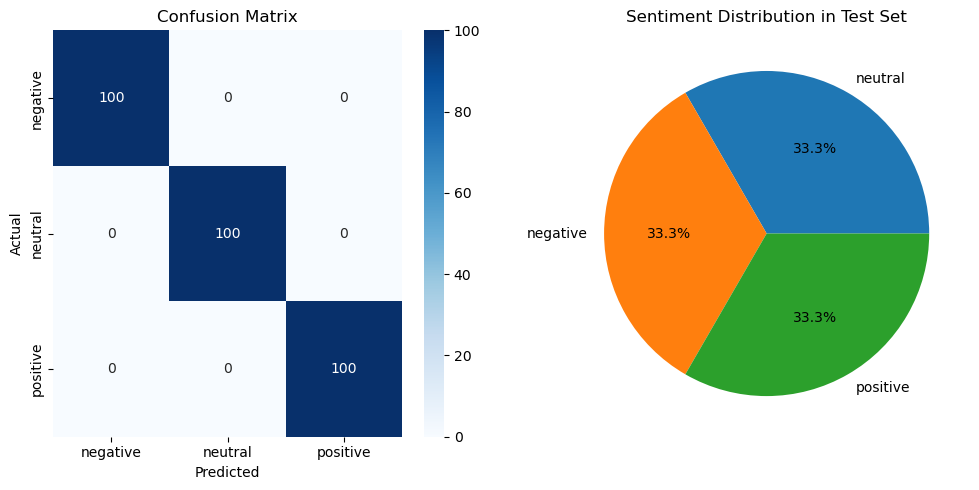


=== Sample Predictions ===

Text: I absolutely love this product! It's incredible!
ML Prediction: positive (confidence: 0.766)
Probabilities: {'negative': 0.13262575535133794, 'neutral': 0.10175824577131296, 'positive': 0.7656159988773491}

Text: This is the worst thing I've ever bought. Terrible quality.
ML Prediction: negative (confidence: 0.843)
Probabilities: {'negative': 0.8432444393870518, 'neutral': 0.06346256280318179, 'positive': 0.0932929978097665}

Text: The product is okay, nothing special but it works.
ML Prediction: neutral (confidence: 0.959)
Probabilities: {'negative': 0.017098432843392648, 'neutral': 0.9590881574739752, 'positive': 0.02381340968263226}

Text: Amazing service! Highly recommend to everyone!
ML Prediction: positive (confidence: 0.762)
Probabilities: {'negative': 0.20395331381328716, 'neutral': 0.03444476311867863, 'positive': 0.7616019230680342}

Text: Poor customer support, very disappointed.
ML Prediction: negative (confidence: 0.916)
Probabilities: {'

In [ ]:
# Advanced features
class AdvancedSentimentAnalyzer(SentimentAnalyzer):
    def __init__(self):
        super().__init__()
        self.aspect_keywords = {
            'quality': ['quality', 'build', 'material', 'construction', 'durability'],
            'service': ['service', 'support', 'staff', 'help', 'assistance'],
            'price': ['price', 'cost', 'expensive', 'cheap', 'value', 'money'],
            'delivery': ['delivery', 'shipping', 'fast', 'slow', 'quick']
        }
    
    def aspect_based_sentiment(self, text):
        """Perform aspect-based sentiment analysis"""
        results = {}
        text_lower = text.lower()
        
        for aspect, keywords in self.aspect_keywords.items():
            if any(keyword in text_lower for keyword in keywords):
                # Extract sentences containing aspect keywords
                sentences = text.split('.')
                aspect_sentences = [s for s in sentences 
                                 if any(keyword in s.lower() for keyword in keywords)]
                
                if aspect_sentences:
                    aspect_text = '. '.join(aspect_sentences)
                    sentiment = self.predict_sentiment(aspect_text)
                    results[aspect] = sentiment['prediction']
        
        return results
    
    def generate_wordcloud(self, df, sentiment_type):
        """Generate word cloud for specific sentiment"""
        if not WORDCLOUD_AVAILABLE:
            print("WordCloud not available. Showing top words instead.")
            sentiment_texts = df[df['sentiment'] == sentiment_type]['text'].str.cat(sep=' ')
            processed_text = self.preprocess_text(sentiment_texts)
            
            if processed_text:
                words = processed_text.split()
                word_freq = {}
                for word in words:
                    word_freq[word] = word_freq.get(word, 0) + 1
                
                top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
                print(f"\nTop 20 words for {sentiment_type} sentiment:")
                for word, freq in top_words:
                    print(f"{word}: {freq}")
            return
        
        sentiment_texts = df[df['sentiment'] == sentiment_type]['text'].str.cat(sep=' ')
        processed_text = self.preprocess_text(sentiment_texts)
        
        if processed_text:
            wordcloud = WordCloud(width=800, height=400, 
                                background_color='white').generate(processed_text)
            
            if PLOTTING_AVAILABLE:
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis('off')
                plt.title(f'{sentiment_type.capitalize()} Sentiment Word Cloud')
                plt.show()

if __name__ == "__main__":
    # Run the main demonstration
    analyzer = main()
    
    # Interactive mode
    print("\n=== Interactive Mode ===")
    print("Enter text to analyze (or 'quit' to exit):")
    
    while True:
        user_input = input("\nEnter text: ")
        if user_input.lower() == 'quit':
            break
        
        if user_input.strip():
            result = analyzer.predict_sentiment(user_input)
            print(f"Sentiment: {result['prediction']}")
            print(f"Confidence: {result['confidence']:.3f}")
            print(f"Probabilities: {result['probabilities']}")